# CLM-CISM downscaling, 20 Oct 2016

CLM forcing fields (acab or SMB, and temperature) are supplied at a coarse horizontal resolution and at 10 vertical levels or elevation classes.

Here I explore some possibilities regarding horizontal and vertical interpolation of these fields to the CISM grid.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Two cells are selected along the Greenland K-transect

In [2]:
coords={} # Coordinates (ilat,ilon) of CLM gridcells
coords['cellA']=(167,248)
coords['cellB']=(167,249)

### Some test data

Yearly average ablation (AB) and accumulation (AC) are taken from an FG run (casename = cam6clm5_beta07_col_119rest_lwlap) with output at each elevation class.

One year averaged data for now, just for testing.

In [18]:
# Elevation class midpoints
elev_mec = np.asarray([100, 300, 550, 850, 1150, 1450, 1800, 2250, 2750, 3500])

In [4]:
ab={}
ab['cellA']=np.asarray([  1.04427941e+01 ,  7.75391426e+00 , 5.62771183e+00,   2.39465291e+00,
   7.41343991e-01 ,  7.64908130e-02 ,  5.09881154e-02  , 1.36675815e-02,
  -1.02899391e-02 , -3.26783274e-02]) * 365 / 1000. # convert from mm/day to m/year
ab['cellB']=np.asarray([  1.53967969e+01,   1.20004906e+01,   8.89361040e+00 ,  3.97812184e+00,
   1.51039940e+00  , 1.65159715e-01 ,  1.29554068e-01  , 7.93311018e-02,
   3.70435832e-02,  -6.42650455e-03]) * 365 / 1000. # convert from mm/day to m/year

In [5]:
ac={}
ac['cellA']=np.asarray([ 0.48337985,  0.62594054,  0.77821437,  0.9810329 ,  1.04418045,  1.12301125,
  1.14667178 , 1.15020953 , 1.15020964,  1.15020964]) * 365 / 1000. # convert from mm/day to m/year
ac['cellB']=np.asarray([ 0.5283285 ,  0.65806491 , 0.80689576 , 1.01173176 , 1.11583912,  1.19848984,
  1.24245121,  1.25205707 , 1.25205707 , 1.25205707]) * 365 / 1000. # convert from mm/day to m/year

SMB can be calculated as AB-AC:

In [6]:
smb = {}
smb['cellA'] = ac['cellA']-ab['cellA']
smb['cellB'] = ac['cellB']-ab['cellB']

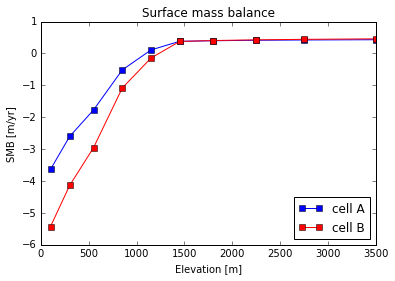

In [7]:
plt.plot(elev_mec,smb['cellA'],'bs-',label='cell A')
plt.plot(elev_mec,smb['cellB'],'rs-',label='cell B')
plt.xlabel('Elevation [m]')
plt.title('Surface mass balance')
plt.ylabel('SMB [m/yr]')
plt.legend(loc='lower right')

### Downscaling options

Now suppose we would like to downscale SMB to a CISM grid cell *P* which is horizontally located exactly midway between cell A and cell B, with some arbitrary elevation:

In [29]:
elev_P = 500. #m

In reality we would consider bilinear interpolation but in this case we can simplify to a linear interpolation, I think without loss of generality. There are several options how to do the downscaling. 

#### Method 1: horizontal then vertical

Horizontally interpolate SMB at each elevation class, then vertically interpolate to the target elevation. 

Number of linear interpolations required: 2x10 + 1 = 21

In [30]:
smb_P = {}
from scipy.interpolate import interp1d
smb_interpolated = 0.5*(smb['cellA']+smb['cellB'])
y_interp = interp1d(elev_mec, smb_interpolated)
smb_P['method1'] = float(y_interp(elev_P))
smb_P['method1']

-2.5628565450650003

#### Method 2: vertical then horizontal

First, vertically interpolate SMB to the target elevation, then do the horizontal interpolation. 

Number of linear interpolations required: 3

In [31]:
y_interpA = interp1d(elev_mec, smb['cellA'])
yA = y_interpA(elev_P)
y_interpB = interp1d(elev_mec, smb['cellB'])
yB = y_interpB(elev_P)
smb_P['method2'] = 0.5*(yA+yB)
smb_P['method2']

-2.5628565450649998

Same answer as with option 1, as we would expect since these are linear operations.

#### Method 3: regression on AB

Consider accumulation and ablation separately. In each CLM grid cell, derive regression parameters a and b for a least-squares regression of ablation with height (this is the method that Noël2016 uses:  http://www.the-cryosphere.net/10/2361/2016/). Then interpolate regression parameters a and b to the target location, call these a_P and b_P. Compute now downscaled ablation as
```
AB_P = a_P + b_P * elev_P
```
For accumulation no elevation correction is required, as this field does not always scale the same way with height (?)

In the test data, ablation (AB) shows a strong correlation with elevation up to about 1200m, after which it levels out:

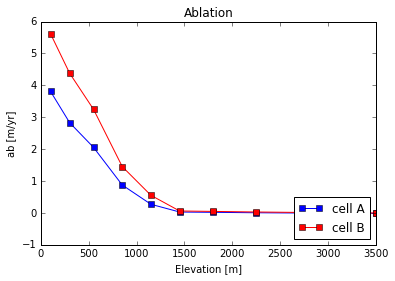

In [32]:
plt.plot(elev_mec,ab['cellA'],'bs-',label='cell A')
plt.plot(elev_mec,ab['cellB'],'rs-',label='cell B')
plt.title('Ablation')
plt.xlabel('Elevation [m]')
plt.ylabel('ab [m/yr]')
plt.legend(loc='lower right')

Applying a linear regression on a variable that has two such distinct regimes is tricky. We better separate the two regimes before regression. The ELA (SMB==0) seems like a natural regime divider:

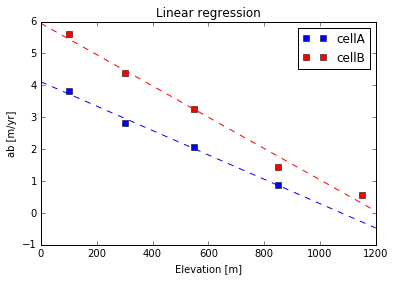

In [33]:
# Only select points that experience net ablation
from scipy.stats import linregress
gradient = {}
intercept = {}
for cell,color in [('cellA','b'),('cellB','r')]:
    x_pos_smb = smb[cell] < 0.
    gradient[cell], intercept[cell], r_value, p_value, std_err = linregress(elev_mec[x_pos_smb],ab[cell][x_pos_smb])
    plt.plot(elev_mec[x_pos_smb],ab[cell][x_pos_smb],color+'s',label=cell)
    xx = np.arange(0,1201)
    plt.plot(xx,intercept[cell]+gradient[cell]*xx,color+'--')

plt.xlabel('Elevation [m]')
plt.title('Linear regression')
plt.ylabel('ab [m/yr]')
plt.legend(loc='upper right')


In [34]:
gradient, intercept

({'cellA': -0.0038208347471587302, 'cellB': -0.0049046200388104672},
 {'cellA': 4.1118660565964289, 'cellB': 5.9436234201181755})

Accumulation strangely enough also shows a elevation gradient, although each elevation class receives the same amount of precipitation. There is a simple explanation for this, namely the rain repartitioning scheme in CLM was enabled in the experiment that these data derive from. Lower elevation classes generally have higher temperatures so less rain is converted to snow. 

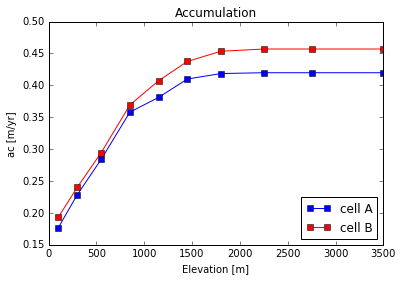

In [35]:
plt.plot(elev_mec,ac['cellA'],'bs-',label='cell A')
plt.plot(elev_mec,ac['cellB'],'rs-',label='cell B')
plt.xlabel('Elevation [m]')
plt.ylabel('ac [m/yr]')
plt.title('Accumulation')
plt.legend(loc='lower right')

SMB at point P is now estimated by interpolating the regression parameters for ablation, and linear interpolation of accumulation.

In [36]:
a_P = 0.5*(intercept['cellA']+intercept['cellB'])
b_P = 0.5*(gradient['cellA']+gradient['cellB'])
ab_P = a_P + b_P * elev_P

In [37]:
y_interpA = interp1d(elev_mec, ac['cellA'])
yA = y_interpA(elev_P)
y_interpB = interp1d(elev_mec, ac['cellB'])
yB = y_interpB(elev_P)
ac_P=0.5*(yA+yB)

In [38]:
smb_P['method3'] = ac_P - ab_P
smb_P

{'method1': -2.5628565450650003,
 'method2': -2.5628565450649998,
 'method3': -2.5680887639600036}